In [1]:
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
!ls ./DATA

Thumbs-Copy1.db    agesonly.csv       matchmaker.csv     zebo-Copy1.txt
addresslist.txt    feedlist-Copy1.txt schedule-Copy1.txt


In [3]:
!head ./DATA/agesonly.csv

In [5]:
! head matchmaker.csv

In [4]:
# code including advancedclassify.py module

class matchrow:
    def __init__(self,row,allnum=False):
        if allnum:
            self.data=[float(row[i]) for i in range(len(row)-1)]
        else:
            self.data=row[0:len(row)-1]
        self.match=int(row[len(row)-1])

def loadmatch(f,allnum=False):
    rows=[]
    for line in open(f):
        rows.append(matchrow(line.split(','),allnum))
    return rows

In [6]:
agesonly=loadmatch('./DATA/agesonly.csv', allnum=True)
matchmaker=loadmatch('./DATA/matchmaker.csv')

In [7]:
def plotagematches(rows):
    xdm, ydm = [r.data[0] for r in rows if r.match==1],\
               [r.data[1] for r in rows if r.match==1]
    xdn, ydn = [r.data[0] for r in rows if r.match==0],\
               [r.data[1] for r in rows if r.match==0]
    plt.plot(xdm, ydm, 'go')
    plt.plot(xdn, ydn, 'rx')
    
    plt.show()

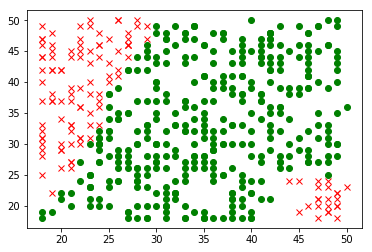

In [8]:
plotagematches(agesonly)

## Decision Tree classify

In [10]:
# basic linear classify

def lineartrain(rows): 
    averages={}
    counts={}
    
    for row in rows:
        cl=row.match
        
        averages.setdefault(cl, [0.0]*(len(row.data)))
        counts.setdefault(cl, 0)
        
        # adding point to average
        for i in range(len(row.data)):
            averages[cl][i] += float(row.data[i])
            
            counts[cl] += 1
            
    for cl, avg in averages.items():
        for i in range(len(avg)):
            avg[i] /= counts[cl]

    return averages

In [11]:
avgs = lineartrain(agesonly)
avgs

{0: [13.457264957264957, 17.944444444444443],
 1: [17.740208877284594, 16.507832898172325]}

In [12]:
def dotproduct(v1, v2):
    return sum([v1[i]*v2[i] for i in range(len(v1))])

In [13]:
# class = sign((X - (M0 + M1)/2) * (M0 - M1)

def dpclassify(point, avgs):
    b = (dotproduct(avgs[1], avgs[1]) - dotproduct(avgs[0], avgs[0]))
    y = dotproduct(point, avgs[0]) - dotproduct(point, avgs[1]) + b
    if y > 0: return 0 # >0, means close
    else: return 1

In [14]:
print(dpclassify([30, 25], avgs),
dpclassify([12, 25], avgs),
dpclassify([48, 20], avgs))

1 0 1


## Categorical features

In [15]:
# yes/no
# convert number to yes/no

def yesno(v):
    if v == 'yes': return 1
    elif v == 'no': return -1
    else: return 0

In [16]:
def matchcount(interest1, interest2):
    l1 = interest1.split(':')
    l2 = interest2.split(':')
    x = 0
    for v in l1:
        if v in l2: x += 1
    return x

In [16]:
yahookey="YOUR API KEY"
from xml.dom.minidom import parseString
from urllib.request import urlopen
from urllib.parse import quote_plus

loc_cache={}
def getlocation(address):
  if address in loc_cache: return loc_cache[address]
  data=urlopen('http://api.local.yahoo.com/MapsService/V1/'+\
               'geocode?appid=%s&location=%s' %
               (yahookey,quote_plus(address))).read()
  doc=parseString(data)
  lat=doc.getElementsByTagName('Latitude')[0].firstChild.nodeValue
  long=doc.getElementsByTagName('Longitude')[0].firstChild.nodeValue  
  loc_cache[address]=(float(lat),float(long))
  return loc_cache[address]

In [17]:
def milesdistance(a1,a2):
  lat1,long1=getlocation(a1)
  lat2,long2=getlocation(a2)
  latdif=69.1*(lat2-lat1)
  longdif=53.0*(long2-long1)
  return (latdif**2+longdif**2)**.5

In [19]:
getlocation('cambridge, ma')

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [ ]:
# creating new data

def loadnumerical():
    oldrows = load('matchmaker.csv')
    newros = []
    for row in oldrows:
        d = row.data
        data = [float(d[0]), yesno(d[1]), yesno(d[2]),
                float(d[5]), yesno(d[6]), yesno(d[7]),
                matchcount(d[3],d[8]),
                mile]

## The Kernel trick

use non linear solution to classify replace linear classify.
use mapping function convert high dimension space

In [17]:
# rbs = radial-basis function

def rbf(v1, v2, gamma=20):
    """
    v1, v2: vector
    gamma: adjust 
    return: scalar
    """
    dv = [v1[i] - v2[i] for i in range(len(v1))]
    l = veclength(dv)
    return math.e**(-gamma*l)

In [18]:
def veclength(v):
    return sum([p**2 for p in v])

In [52]:
import math

def nlclassify(point, rows, offset, gamma=10):
    # non linear classify
    sum0=0.0
    sum1=0.0
    count0=0
    count1=0
    
    for row in rows:
        if row.match==0:
            sum0+=rbf(point, row.data, gamma)
            count0+=1
        else:
            sum1+=rbf(point, row.data, gamma)
            count1+=1
    y=(1.0/count0)*sum0-(1.0/count1)*sum1 + offset
    
    if y<0: return 0
    else: return 1
    
def getoffset(rows, gamma=0):
    l0=[]
    l1=[]
    for row in rows:
        if row.match==0: l0.append(row.data)
        else: l1.append(row.data)
    sum0=sum(sum([rbf(v1, v2, gamma) for v1 in l0]) for v2 in l0)
    sum1=sum(sum([rbf(v1, v2, gamma) for v1 in l1]) for v2 in l1)
    
    return (1.0/(len(l1)**2))*sum1-(1.0/(len(l0)**2))*sum0

In [57]:
offset=getoffset(agesonly)

In [59]:
nlclassify([30, 30], agesonly, getoffset)

TypeError: unsupported operand type(s) for +: 'float' and 'function'

##

SVM: try to find a maximum-margin hyperplane, closed line points call support vector.

In [60]:
from sklearn import svm

In [66]:
X = [[1, 0, 1], [-1, 0, 1]]
y = [1, -1]
clf = svm.SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
clf.support_vectors_

array([[-1.,  0.,  1.],
       [ 1.,  0.,  1.]])

In [68]:
clf = svm.SVC(kernel='linear',C=10)
clf.fit(X, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [69]:
clf.support_vectors_

array([[-1.,  0.,  1.],
       [ 1.,  0.,  1.]])

In [71]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

In [73]:
y[:5]

array([0, 0, 0, 0, 0])

Automatically created module for IPython interactive environment


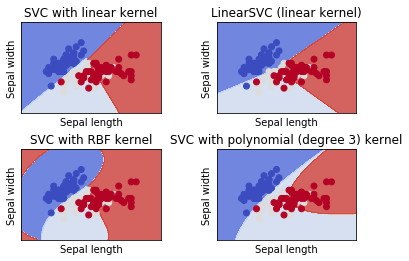

In [76]:
# Plot different SVM classifiers in the iris dataset

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()